In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="*")
project = rf.workspace("cdlrd").project("radiologue")
dataset = project.version(1).download("coco")

In [ ]:
rf = Roboflow(api_key="*")
project = rf.workspace("cdlrd").project("radiologue")
dataset = project.version(1).download("coco")

<html>
<center>
<h3><b> YOLO NAS </h3></b>
<body>
    <img src="Image_\YOLONAS_.png", width= "75%", height= "75%">
</body>
</center>
</html>

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

1.12.1+cu116
True
NVIDIA GeForce GTX 1660 Ti


<h4> <b> Fine-tuning YOLO-NAS

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name = '__yolonas_run__', ckpt_root_dir = CHECKPOINT_DIR)

LOCATION = 'axialMRI/radiologue-1'
CLASSES = 'maladie'

In [ ]:
"""
radiologue-1
├── data.yaml
└── Train
│   └── images_train
│   └── labels_train
└── Test
│   └── images_test
│   └── labels_test
└── Vaild
    └── images_val
    └── labels_val
"""

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [12]:
''' parameters '''
epcohs = 100
batch_size = 16
workers = 2

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params = {
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes'],
    },
    dataloader_params={
        'shuffle': True,
        'batch_size': batch_size,
        'num_workers': workers
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes'],
    },
    dataloader_params={
        'batch_size': batch_size,
        'num_workers': workers,
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': batch_size,
        'num_workers': workers
    }
)

Caching annotations: 100%|██████████| 1560/1560 [00:00<00:00, 3867.70it/s]


Caching annotations: 100%|██████████| 95/95 [00:00<00:00, 3868.01it/s]


In [ ]:
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': batch_size,
        'num_workers': workers
    }
)

Caching annotations:  99%|█████████▉| 94/95 [02:02<00:01,  1.30s/it]

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

> Augmentations like **mosaic**, **rotation**, **zoom in**, and **zoom out** have also been applied to the images.

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

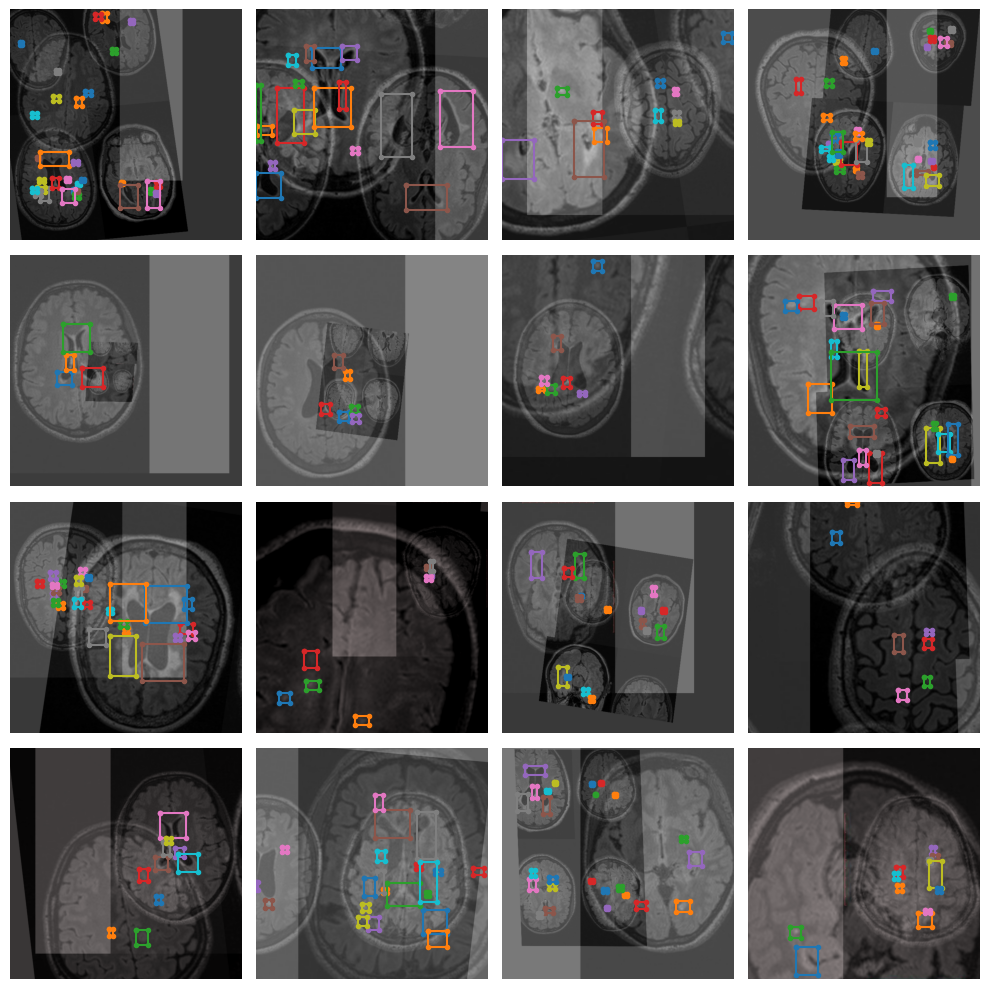

In [ ]:
train_data.dataset.plot()

In [ ]:
'''
'yolo_nas_s', 'yolo_nas_m', 'yolo_nas_l'
'''
from super_gradients.training import models

model_yolo_nas = models.get('yolo_nas_l',
                        num_classes= len(dataset_params['classes']),
                        pretrained_weights = "coco")

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": epcohs,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes= len(dataset_params['classes']),
        reg_max= 16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres= 0.1,
            top_k_predictions= 300,
            num_cls= len(dataset_params['classes']),
            normalize_targets= True,
            post_prediction_callback= PPYoloEPostPredictionCallback(
                                                score_threshold=0.01,
                                                nms_top_k=1000,
                                                max_predictions=300,
                                                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model = model_yolo_nas,
                training_params= train_params,
                train_loader= train_data,
                valid_loader= val_data)

> best weights: checkpoint_path = checkpoints/__yolonas_run__/ckpt_best.pth

> last weights: checkpoint_path = checkpoints/_yolonas_run__/ckpt_latest.pth

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes= len(dataset_params['classes']),
                        checkpoint_path="checkpoints/__yolonas_run__/ckpt_best.pth")

In [ ]:
prediction_callback= PPYoloEPostPredictionCallback(score_threshold = 0.01,
                                                        nms_top_k = 1000,
                                                        max_predictions = 300,
                                                        nms_threshold = 0.7)

trainer.test(model= best_model,
                test_loader= test_data,
                test_metrics_list= DetectionMetrics_050(
                        score_thres= 0.1,
                        top_k_predictions= 300,
                        num_cls = len(dataset_params['classes']),
                                normalize_targets= True,
                                post_prediction_callback= prediction_callback))

Testing: 100%|██████████| 6/6 [07:52<00:00, 78.77s/it]


{'Precision@0.50': 0.0403926856815815,
 'Recall@0.50': 0.9590747356414795,
 'mAP@0.50': 0.709887683391571,
 'F1@0.50': 0.07752048969268799}

In [ ]:
import os
import random

def get_random_images(folder_path, num_images=5):
    all_files = os.listdir(folder_path)
    image_files = [file for file in all_files if file.endswith(".jpg") or file.endswith(".png")]
    if len(image_files) < num_images:
        raise ValueError("Không đủ ảnh trong thư mục.")
    random_images = random.sample(image_files, num_images)
    full_paths = [os.path.join(folder_path, image) for image in random_images]
    return full_paths

folder_path = "/content/drive/MyDrive/axialMRI/radiologue-1/test/images/"
random_images = get_random_images(folder_path, 5)

Predicting Images:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
[2023-08-06 17:52:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


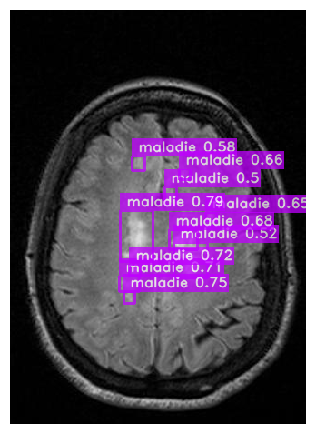

Predicting Images: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


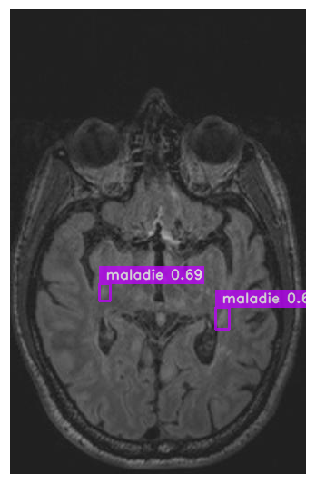

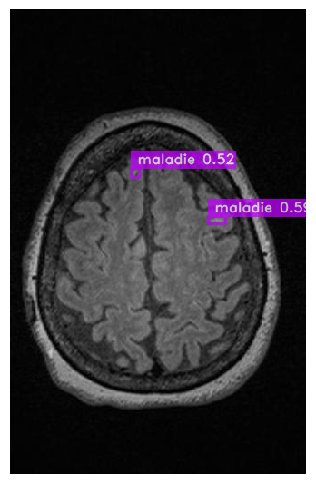

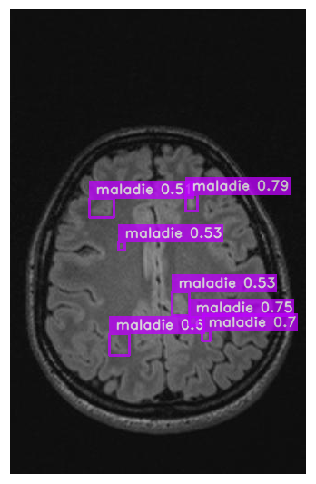

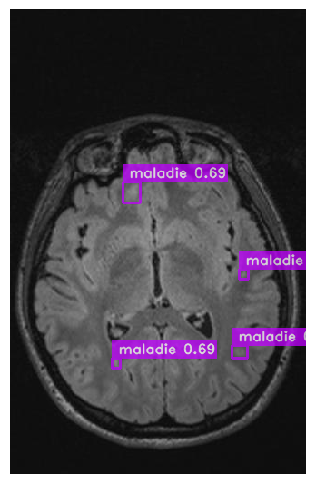

In [ ]:
best_model.predict(random_images).show()

In [ ]:
random_images[0]

['/content/drive/MyDrive/axialMRI/radiologue-1/test/images/IMG-0008-00188_jpg.rf.c4a8e791a80169067d8c1ba5a9bf7d5d.jpg',
 '/content/drive/MyDrive/axialMRI/radiologue-1/test/images/IMG-0006-00142_jpg.rf.d979f7cb3b45bbaf4831184eb612c86b.jpg',
 '/content/drive/MyDrive/axialMRI/radiologue-1/test/images/IMG-0008-00195_jpg.rf.1bf229bfb61071978d2e638008b56d85.jpg',
 '/content/drive/MyDrive/axialMRI/radiologue-1/test/images/IMG-0001-00154_jpg.rf.1630f5b97e514e3a35b77b33b5157a40.jpg',
 '/content/drive/MyDrive/axialMRI/radiologue-1/test/images/IMG-0008-00172_jpg.rf.09c46642569427254fafba7bcf44dfe4.jpg']

In [ ]:
prediction = best_model.predict(random_images[0], conf = 0.5)
prediction_info = prediction._images_prediction_lst[0]
bboxes = prediction_info.prediction.bboxes_xyxy
confidences = prediction_info.prediction.confidence
labels = prediction_info.prediction.labels
class_names = prediction_info.class_names
print("Bounding boxes:", bboxes)
print("Confidences:", confidences)
print("Labels:", labels)
print("Class names:", class_names)

[2023-08-06 18:39:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Bounding boxes: [[121.207375 221.1678   157.07233  277.04874 ]
 [125.4081   310.25018  137.88235  323.13086 ]
 [131.65034  280.8918   143.93637  293.55292 ]
 [120.80686  293.82037  142.13751  310.31702 ]
 [175.80042  242.54466  206.83826  264.842   ]
 [186.03525  175.08813  198.85147  187.49554 ]
 [215.85495  223.3716   227.24911  232.03284 ]
 [134.0913   161.3464   148.91309  177.72742 ]
 [180.7795   256.137    217.3617   295.922   ]
 [170.21175  195.17838  183.6383   215.32324 ]]
Confidences: [0.79324746 0.7546329  0.7155161  0.70521706 0.67867273 0.66313356
 0.6486683  0.58373606 0.52219886 0.5034254 ]
Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class names: ['maladie']


[2023-08-06 19:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


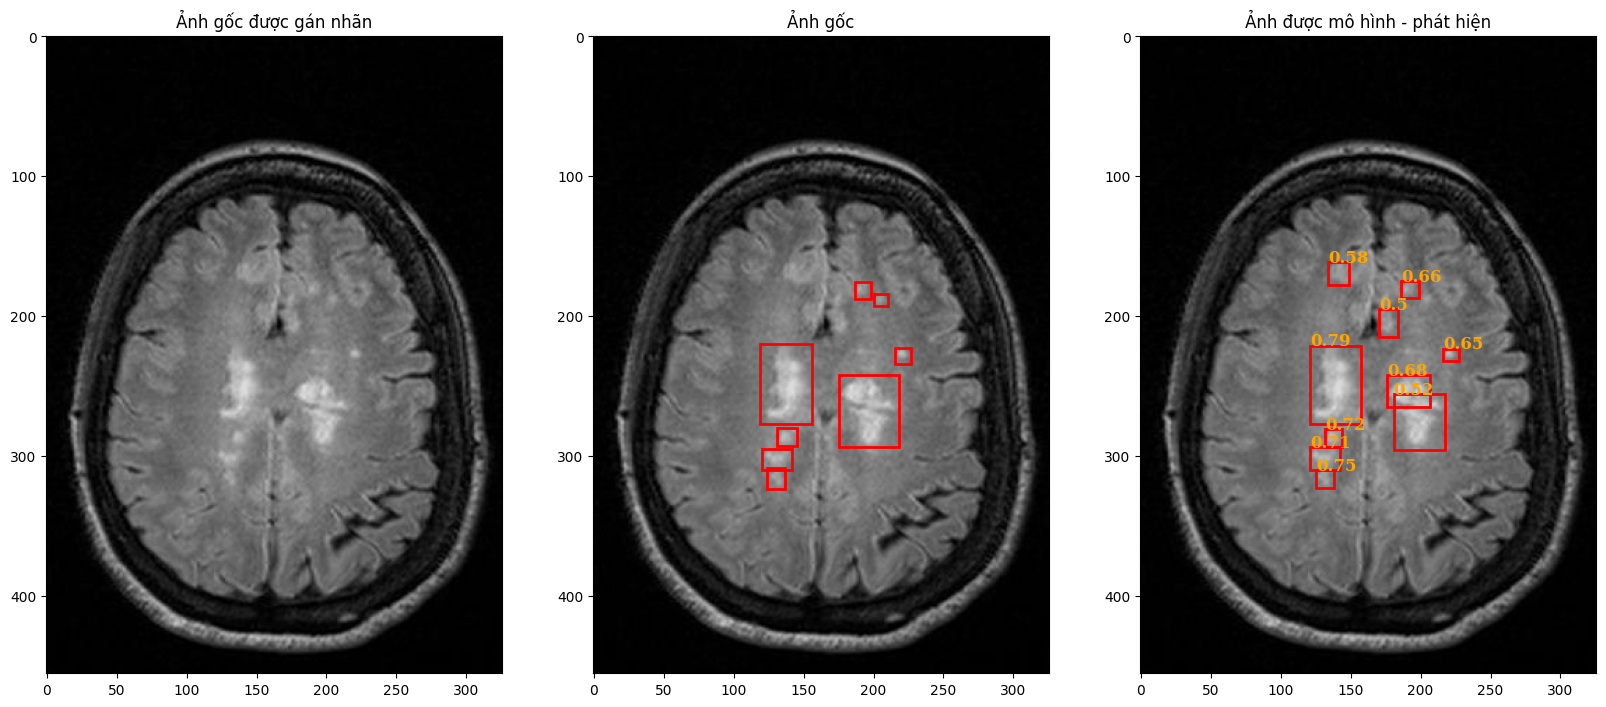

In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def __visualize__(path_image_, conf):
  fig, ax = plt.subplots(1, 3, figsize=(20, 10))

  _image_ = Image.open(path_image_)
  """
  Hiển thị ảnh gốc, ảnh test và ảnh được Detec.
  Tham số:
    path_image_: path ảnh đầu vào.
  """
  # Hiển thị ảnh gốc.
  ax[0].imshow(_image_)
  ax[0].set_title("Ảnh gốc được gán nhãn")

  # Hiển thị ảnh test.
  path_label_ = os.path.dirname(path_image_).split('/images')[-2]+'/labels/' + os.path.basename(path_image_).split('.jpg')[0]+'.txt'
  with open(path_label_, 'r') as f:
    labels_list = [line.strip() for line in f]

  ax[1].imshow(_image_)
  ax[1].set_title("Ảnh gốc")
  for label_str in labels_list:
    label_values = [float(x) for x in label_str.split()]
    class_label = int(label_values[0]) # Labels
    x_center, y_center, width, height = label_values[1:]

    left = (x_center - width / 2) * _image_.width
    top = (y_center - height / 2) * _image_.height
    right = (x_center + width / 2) * _image_.width
    bottom = (y_center + height / 2) * _image_.height

    rect = patches.Rectangle((left, top), right - left, bottom - top,
                                  linewidth= 2,
                                  edgecolor= 'r',
                                  facecolor= 'none', fill=False)
    ax[1].add_patch(rect)

  # Mô hình Detec
  prediction_info = best_model.predict(_image_, conf = conf)._images_prediction_lst[0]
  labels = prediction_info.prediction.labels
  bboxes_xyxy = prediction_info.prediction.bboxes_xyxy
  confidences = prediction_info.prediction.confidence
  # Hiển thị ảnh test.
  ax[2].imshow(_image_)
  ax[2].set_title("Ảnh được mô hình - phát hiện")

  for bboxe_, confidence_ in zip(bboxes_xyxy, confidences):
    x_min, y_min, x_max, y_max = bboxe_
    width = x_max - x_min
    height = y_max - y_min

    rect = patches.Rectangle((x_min, y_min), width, height,
                                  linewidth= 2,
                                  edgecolor= 'r', # violet
                                  facecolor= 'none', fill=False)
    ax[2].add_patch(rect)
    label = (confidence_)
    ax[2].text(x_min, y_min, round(label, 2), weight='bold', fontsize = 12, color= 'orange', fontfamily= 'serif')
  plt.show()
__visualize__(random_images[0], conf= 0.5)